In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv("Retail and wherehouse Sale.csv")

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              30000 non-null  int64  
 1   MONTH             30000 non-null  int64  
 2   SUPPLIER          29967 non-null  object 
 3   ITEM CODE         30000 non-null  object 
 4   ITEM DESCRIPTION  30000 non-null  object 
 5   ITEM TYPE         30000 non-null  object 
 6   RETAIL SALES      29999 non-null  float64
 7   RETAIL TRANSFERS  30000 non-null  float64
 8   WAREHOUSE SALES   30000 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.1+ MB


,YEAR,MONTH,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
count,30000.0,30000.000000,29999.000000,30000.000000,30000.000000
mean,2020.0,3.911467,6.939796,6.594058,27.431031
std,0.0,2.836788,33.081054,27.879428,272.166085
min,2020.0,1.000000,-0.420000,-6.000000,-3999.000000
25%,2020.0,1.000000,0.000000,0.000000,0.000000
50%,2020.0,3.000000,0.160000,0.000000,1.000000
75%,2020.0,7.000000,2.920000,3.000000,6.000000
max,2020.0,9.000000,2739.000000,1507.000000,18317.000000


In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.columns = [
    'year',
    'month',
    'supplier',
    'item_code',
    'item_description',
    'item_type',
    'retail_sales',
    'retail_transfers',
    'warehouse_sales'
]
df.head()

,year,month,supplier,item_code,item_description,item_type,retail_sales,retail_transfers,warehouse_sales
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0


### Handling missing values

In [14]:
df.isnull().sum()

year                 0
month                0
supplier            33
item_code            0
item_description     0
item_type            0
retail_sales         1
retail_transfers     0
warehouse_sales      0
dtype: int64

In [15]:
df['supplier']=df['supplier'].fillna('Unknown')

In [16]:
df.loc[df['retail_sales'].isna(),
       ['retail_sales','retail_transfers','warehouse_sales']]

,retail_sales,retail_transfers,warehouse_sales
18390,NaN,0.0,0.0


##### Retail sales contained a small number of NaN values. Upon inspection, these records showed zero values in transfer and warehouse sales, indicating no retail transaction rather than missing data. Therefore, NaN values were replaced with zero to correctly represent the absence of sales and ensure accurate aggregation.

In [17]:
df['retail_sales']=df['retail_sales'].fillna(0)

In [18]:
df.isnull().sum()

year                0
month               0
supplier            0
item_code           0
item_description    0
item_type           0
retail_sales        0
retail_transfers    0
warehouse_sales     0
dtype: int64

### Creating columns

In [19]:
df['total_sales'] = (
    df['retail_sales'] +
    df['retail_transfers'] +
    df['warehouse_sales']
)

In [20]:
df['gross_sales'] = (
    df[['retail_sales','warehouse_sales','retail_transfers']]
    .clip(lower=0)
    .sum(axis=1)
)

df['adjustments'] = df['total_sales'] - df['gross_sales']

##### Gross sales and adjustments are retained to distinguish operational activity from net sales impact and to correctly interpret negative sales.

In [21]:
df['channel_count'] = (
    (df['retail_sales'] != 0).astype(int) +
    (df['retail_transfers'] != 0).astype(int) +
    (df['warehouse_sales'] != 0).astype(int)
)

In [22]:
df['dominant_sale_channel'] = (
    df[['retail_sales','warehouse_sales','retail_transfers']]
    .abs()
    .idxmax(axis=1)
    .map({
        'retail_sales': 'Retail',
        'warehouse_sales': 'Warehouse',
        'retail_transfers': 'Transfers'
    })
)

df.loc[df['total_sales'] == 0, 'dominant_sale_channel'] = 'No Activity'

# Dominant channel is therefore defined based on the absolute magnitude of channel values to correctly capture the primary driver of activity, including returns and credits.

df.tail(10)

,year,month,supplier,item_code,item_description,item_type,retail_sales,retail_transfers,warehouse_sales,total_sales,gross_sales,adjustments,channel_count,dominant_sale_channel
29990,2020,3,TRICANA SHIPPERS & IMPORT,352268,E' ARTE PRIMITIVO - 750ML,WINE,0.00,0.0,1.0,1.00,1.00,0.0,1,Warehouse
29991,2020,3,ARTISANS & VINES LLC,352290,CHARLES PERE & FILLE BOURGOGNE ROUGE - 750ML,WINE,0.00,0.0,4.0,4.00,4.00,0.0,1,Warehouse
29992,2020,3,"THE COUNTRY VINTNER, LLC DBA WINEBOW",352292,DOM LAFAGE COTE EST - 750ML,WINE,0.00,0.0,6.0,6.00,6.00,0.0,1,Warehouse
29993,2020,3,ARTISANS & VINES LLC,352308,CH CARIGNAN ROUGE - 750ML,WINE,0.00,0.0,2.0,2.00,2.00,0.0,1,Warehouse
29994,2020,3,"THE COUNTRY VINTNER, LLC DBA WINEBOW",352320,CINCO SENTIDOS PAPALOMETL MEZCAL - 750ML,LIQUOR,0.00,0.0,1.0,1.00,1.00,0.0,1,Warehouse
29995,2020,3,"THE COUNTRY VINTNER, LLC DBA WINEBOW",352322,FORTALEZA ANEJO TEQUILA - 750ML,LIQUOR,0.33,0.0,0.0,0.33,0.33,0.0,1,Retail
29996,2020,3,OSLO ENTERPRISE,352324,DOMAINE BRICHOT BLANC - 750ML,WINE,0.00,0.0,0.0,0.00,0.00,0.0,0,No Activity
29997,2020,3,OPICI FAMILY DISTRIBUTING OF MD,352354,LOTE 44 MALBEC - 750ML,WINE,0.00,0.0,6.0,6.00,6.00,0.0,1,Warehouse
29998,2020,3,CAMPARI AMERICA LLC,35238,SKYY VODKA - 1.75L,LIQUOR,329.04,302.0,0.0,631.04,631.04,0.0,2,Retail
29999,2020,3,"THE COUNTRY VINTNER, LLC DBA WINEBOW",352380,CH HAUT LA PEREYRE BORD BLANC - 750ML,WINE,0.00,0.0,1.0,1.00,1.00,0.0,1,Warehouse


### Core Metric Validation – total_sales

In [23]:
df['total_sales'].describe()

count    30000.000000
mean        40.964654
std        307.499493
min      -3999.000000
25%          1.000000
50%          3.000000
75%         15.000000
max      20532.000000
Name: total_sales, dtype: float64

#### Highly right-skewed distribution
#### 75% of total sale is <=15 units
#### Large negative values exist due to returns

### Zero Sales Analysis

In [24]:
zero_sales_pct = (df['total_sales'] == 0).mean() * 100
zero_sales_pct

np.float64(0.25)

In [25]:
df_zero = df[df['total_sales'] == 0]

df_zero.groupby('item_type').size().sort_values(ascending=False)

item_type
WINE           49
KEGS           10
BEER            8
LIQUOR          6
NON-ALCOHOL     2
dtype: int64

##### Only 0.25% of records show zero total sales. These are mostly wine products, which likely reflects the large number of wine SKUs

### Negative Sales Analysis (Returns & Adjustments)

In [26]:
(df['total_sales'] < 0).mean() * 100

np.float64(0.27)

In [27]:
neg_df = df[df['total_sales'] < 0]
neg_df[['retail_sales','retail_transfers','warehouse_sales']].sum()

retail_sales            2.90
retail_transfers      -10.20
warehouse_sales    -13510.57
dtype: float64

##### For records with negative total sales, the impact is driven almost entirely by large negative warehouse sales, while retail sales remain marginally positive. This indicates that the negative totals are the result of warehouse-level operational adjustments rather than a decline in retail demand.

In [28]:
neg_df.sort_values('total_sales').head(15)[
        [
            'item_description',
            'item_type',
            'retail_sales',
            'retail_transfers',
            'warehouse_sales',
            'total_sales'
        ]
    ]

,item_description,item_type,retail_sales,retail_transfers,warehouse_sales,total_sales
822,EMPTY 1/2 KEG (30.00),DUNNAGE,0.0,0.0,-3999.0,-3999.0
25136,EMPTY 1/2 KEG (30.00),DUNNAGE,0.0,0.0,-2070.0,-2070.0
24176,EMPTY 1/2 KEG (30.00),DUNNAGE,0.0,0.0,-1876.0,-1876.0
12786,EMPTY 1/2 KEG (30.00),DUNNAGE,0.0,0.0,-1675.0,-1675.0
11985,BEER CREDIT,REF,0.0,0.0,-1028.0,-1028.0
1011,EMPTY 1/6 KEG (30.00),DUNNAGE,0.0,0.0,-934.0,-934.0
25325,EMPTY 1/6 KEG (30.00),DUNNAGE,0.0,0.0,-562.0,-562.0
12965,EMPTY 1/6 KEG (30.00),DUNNAGE,0.0,0.0,-362.0,-362.0
2310,EMPTY 1/4 KEG (30.00),DUNNAGE,0.0,0.0,-287.0,-287.0
23212,BEER CREDIT,REF,0.0,0.0,-190.0,-190.0


##### The most negative sales records are dominated by DUNNAGE items (empty kegs) and REF items (beer and wine credits). All negative values are driven entirely by warehouse sales, with zero retail sales and transfers, confirming that these entries represent keg returns and accounting credits rather than negative customer demand.

### Channel-wise analysis

In [29]:
channel_totals = df[['retail_sales','warehouse_sales','retail_transfers']].sum()

channel_share = (
    channel_totals / channel_totals.sum()
).round(3)

channel_totals, channel_share

(retail_sales        208186.94
 warehouse_sales     822930.93
 retail_transfers    197821.74
 dtype: float64,
 retail_sales        0.169
 warehouse_sales     0.670
 retail_transfers    0.161
 dtype: float64)

In [30]:
df['channel_count'].value_counts().sort_index()

channel_count_dist = (
    df['channel_count'].value_counts().sort_index(),
    df['channel_count']
    .value_counts(normalize=True)
    .sort_index()
    .round(3)
)

channel_count_dist


(channel_count
 0       75
 1    17625
 2     5280
 3     7020
 Name: count, dtype: int64,
 channel_count
 0    0.002
 1    0.588
 2    0.176
 3    0.234
 Name: proportion, dtype: float64)

In [31]:
df.groupby('channel_count')['total_sales'].agg([
    'count','mean','median','sum'
])

,count,mean,median,sum
channel_count,,,,
0,75,0.000000,0.000,0.00
1,17625,9.308703,1.000,164065.89
2,5280,19.442667,5.415,102657.28
3,7020,137.067869,33.320,962216.44


##### Most of the total sales in this data come from the warehouse. About two-thirds of all volume moves through the warehouse, while retail sales and transfers each make up a much smaller share. This shows that the data mostly reflects inventory movement and distribution, not just customer purchases.

##### Looking at products individually, most items are active in only one channel. However, items that appear in more than one channel tend to sell much more overall. Products active in two channels sell more than single-channel products, and products active in all three channels sell far more than either.

##### In short, using more channels is linked with higher sales. High-volume products almost always move through multiple channels, while low-volume products tend to stay in just one. This does not prove that adding channels causes higher sales, but it clearly shows that higher-selling products are usually active in more than one channel.

### Supplier Sales and Sales per Item

In [33]:
supplier_df = (
    df.groupby('supplier')
    .agg(
        total_sales=('total_sales', 'sum'),
        item_count=('item_code', 'nunique')
    )
    .assign(
        sales_per_item=lambda x: x['total_sales'] / x['item_count']
    )
    .sort_values('total_sales', ascending=False)
)

supplier_df['contri_percent'] = (
    round(supplier_df['total_sales'] / supplier_df['total_sales'].sum() * 100, 2)
)

supplier_df.head(10)


,total_sales,item_count,sales_per_item,contri_percent
supplier,,,,
CROWN IMPORTS,201333.62,61,3300.551148,16.38
ANHEUSER BUSCH INC,156974.66,258,608.428915,12.77
MILLER BREWING COMPANY,139906.08,144,971.570000,11.38
HEINEKEN USA,103198.20,55,1876.330909,8.40
DIAGEO NORTH AMERICA INC,47893.88,310,154.496387,3.90
BOSTON BEER CORPORATION,44506.03,134,332.134552,3.62
E & J GALLO WINERY,42446.65,454,93.494824,3.45
CONSTELLATION BRANDS,30592.61,277,110.442635,2.49
FLYING DOG BREWERY LLLP,21040.00,78,269.743590,1.71


##### A small number of suppliers account for a large share of total sales. The top suppliers contribute a significant portion of overall volume, indicating that sales are concentrated among a few major players.

##### However, total sales alone do not fully reflect supplier performance. When sales are viewed per item, supplier efficiency varies widely. Some suppliers generate high sales with relatively few items, while others rely on a large number of low-volume items.

##### For example, CROWN IMPORTS and HEINEKEN achieve strong sales per item, whereas suppliers such as DIAGEO sell many items but generate much lower sales per item. This shows that supplier scale and supplier efficiency are not always aligned.

### Gross Sales vs Total Sales by Item Type

In [34]:
df.groupby('item_type').agg(
    gross_sales=('gross_sales','sum'),
    total_sales=('total_sales','sum'),
).sort_values('gross_sales', ascending=False)


,gross_sales,total_sales
item_type,,
BEER,812568.77,812548.27
WINE,237803.43,237777.90
LIQUOR,170145.79,170139.45
NON-ALCOHOL,12197.12,12197.12
KEGS,8444.00,8400.00
STR_SUPPLIES,1240.60,1240.60
REF,80.35,-1248.73
DUNNAGE,0.00,-12115.00


##### For core product categories such as Beer, Wine, Liquor, and Non-Alcohol, total sales closely match gross sales, showing that returns and adjustments are minimal.

##### Negative totals appear only in REF and DUNNAGE, which represent operational items such as credits and container returns rather than customer sales.

### Monthly sale analysis

In [35]:
df.groupby('month')['total_sales'].sum()

month
1    434430.84
3    182334.20
7    595339.95
9     16834.62
Name: total_sales, dtype: float64

##### Only four non-consecutive months are available, which is insufficient to infer seasonality. Observed variation reflects snapshot volatility, not trend.

In [36]:
df.to_csv("final_retail_and_warehouse_sales.csv", index=False)

## Visualisation

In [40]:
import matplotlib.pyplot as plt
df = pd.read_csv("final_retail_and_warehouse_sales.csv")

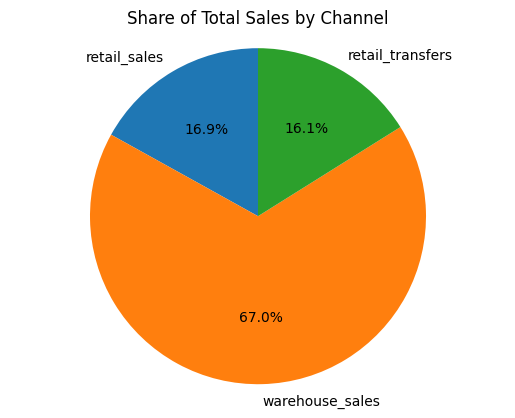

In [41]:
plt.figure()
plt.pie(
    channel_totals,
    labels=channel_totals.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Share of Total Sales by Channel")
plt.axis('equal')
plt.show()


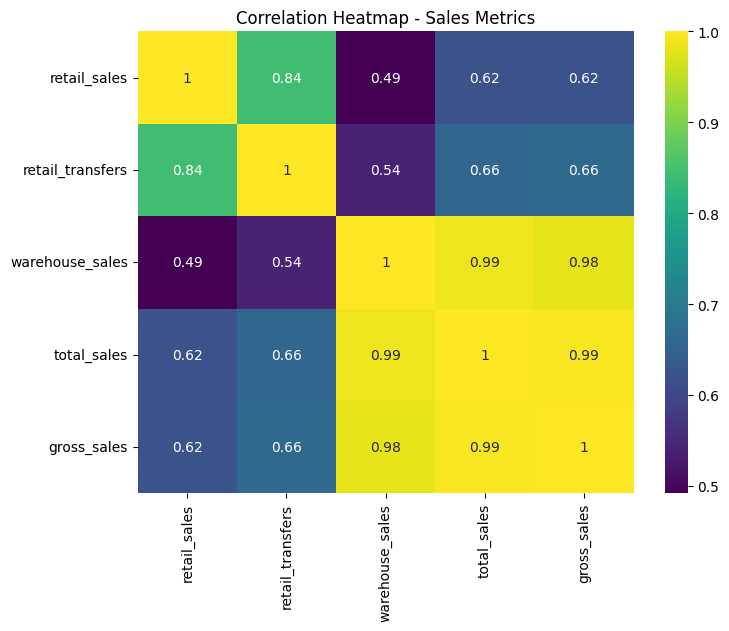

In [42]:
import seaborn as sns
corr_cols = [
    'retail_sales',
    'retail_transfers',
    'warehouse_sales',
    'total_sales',
    'gross_sales'
]

plt.figure(figsize=(8,6))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap - Sales Metrics")
plt.show()

##### Revenue depends largely on warehouse-driven sales, making warehouse distribution the key revenue channel

<Figure size 640x480 with 0 Axes>

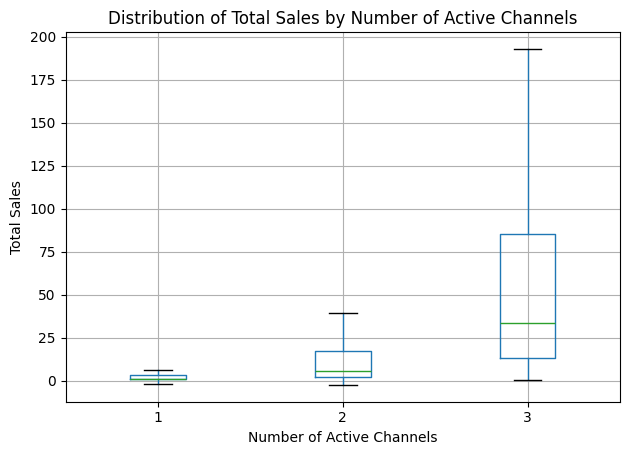

In [43]:
filtered = df[df['channel_count'] > 0]

plt.figure()
filtered.boxplot(
    column='total_sales',
    by='channel_count',
    showfliers=False
)
plt.title("Distribution of Total Sales by Number of Active Channels")
plt.suptitle("")
plt.xlabel("Number of Active Channels")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()


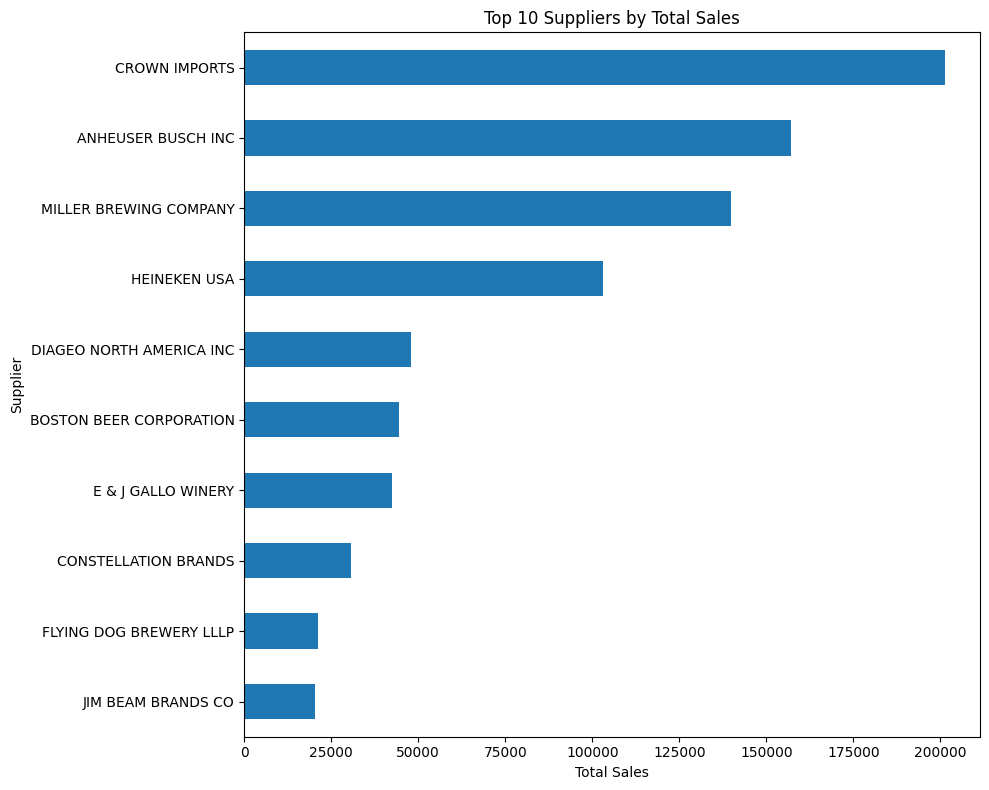

In [48]:
top_suppliers = (
    df.groupby('supplier')['total_sales']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 8)) 
top_suppliers.sort_values().plot(kind='barh')
plt.title("Top 10 Suppliers by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Supplier")
plt.tight_layout()
plt.show()


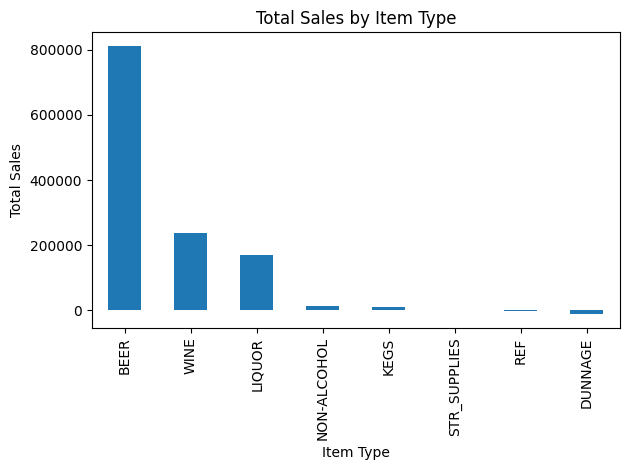

In [49]:
item_type_sales = (
    df.groupby('item_type')['total_sales']
      .sum()
      .sort_values(ascending=False)
)

import matplotlib.pyplot as plt

plt.figure()
item_type_sales.plot(kind='bar')
plt.title('Total Sales by Item Type')
plt.xlabel('Item Type')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()
